# -----import package-----

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import seaborn as sns
from shapely.ops import linemerge
from shapely.wkt import loads
from shapely.geometry import LineString
from shapely.geometry import Point, Polygon
from scipy.spatial import Delaunay

# -----point file-----

In [2]:
df_point = gpd.read_file('hydrant_location.shp')

In [3]:
df_point['id'] = df_point.reset_index().index

In [4]:
df_point

,geometry,id
0,POINT (-74.00698 40.74748),0
1,POINT (-74.00722 40.74722),1
2,POINT (-74.00721 40.74697),2
3,POINT (-74.00722 40.74722),3
4,POINT (-74.00728 40.74667),4
...,...,...
2295,POINT (-73.97976 40.71559),2295
2296,POINT (-73.97987 40.71361),2296
2297,POINT (-73.98387 40.72077),2297
2298,POINT (-73.97780 40.71833),2298


# -----road file-----

In [5]:
df_road = gpd.read_file('road_location/road_location.shp')

In [6]:
df_road.drop('road_id', axis=1, inplace=True)

In [7]:
df_road

,id,geometry
0,1,"LINESTRING (-74.01301 40.70215, -74.01167 40.7..."
1,1,"LINESTRING (-74.01171 40.70247, -74.00999 40.7..."
2,1,"LINESTRING (-74.00577 40.70566, -74.00396 40.7..."
3,1,"LINESTRING (-74.00385 40.70651, -74.00142 40.7..."
4,2,"LINESTRING (-74.01270 40.70275, -74.01180 40.7..."
...,...,...
331,248,"LINESTRING (-73.99741 40.72164, -73.99389 40.7..."
332,249,"LINESTRING (-74.00203 40.71159, -74.00252 40.7..."
333,250,"LINESTRING (-74.00296 40.71334, -74.00150 40.7..."
334,251,"LINESTRING (-74.00799 40.70899, -74.00720 40.7..."


# -----calculate distance between road and point-----

In [8]:
#find the 1 closest road for each point
def find_close_road(point, roads_df):
    close_road = None
    min_distance = float('inf')

    for idx, road in roads_df.iterrows():
        distance = point.distance(road['geometry'])
        if distance < min_distance:
            min_distance = distance
            close_road = road['id']
    return close_road

In [9]:
#apply above method to all points in df_point
df_point['close_road'] = df_point.apply(lambda row: find_close_road(row['geometry'], df_road), axis=1)

In [10]:
def find_closest_road(point, roads_df, min_distance):
    closest_road_id = []

    for idx, road in roads_df.iterrows():
        distance = point.distance(road['geometry'])
        if distance < min_distance:
            closest_road_id.append(road['id'])

    return closest_road_id

In [11]:
df_point['closest_road_id'] = df_point.apply(lambda row: find_closest_road(row['geometry'], df_road, 0.0004), axis=1)

In [12]:
df_point

,geometry,id,close_road,closest_road_id
0,POINT (-74.00698 40.74748),0,119,"[119, 170]"
1,POINT (-74.00722 40.74722),1,119,"[119, 120, 170]"
2,POINT (-74.00721 40.74697),2,120,"[120, 170]"
3,POINT (-74.00722 40.74722),3,119,"[119, 120, 170]"
4,POINT (-74.00728 40.74667),4,120,"[120, 121, 170]"
...,...,...,...,...
2295,POINT (-73.97976 40.71559),2295,234,"[33, 234]"
2296,POINT (-73.97987 40.71361),2296,30,"[30, 35, 235]"
2297,POINT (-73.98387 40.72077),2297,221,[221]
2298,POINT (-73.97780 40.71833),2298,199,"[199, 235]"


# -----block file-----

In [13]:
def blockInfo(shapefile):
    gdf = gpd.read_file(shapefile)
    block_info_list = []
    for idx, row in gdf.iterrows():
        block_id = row['id']
        polygon = row['geometry']
        corners = list(polygon.exterior.coords)
        block_info = {
            'blockID': block_id,
            'corners': corners
        }
        block_info_list.append(block_info)
    return block_info_list

In [14]:
def blockIdentify(hydrantCenter, blocks):
    hydrantPoint = Point(hydrantCenter)
    for block in blocks:
        blockCoords = block['corners']
        blockPolygon = Polygon(blockCoords)
        if hydrantPoint.within(blockPolygon):
            hydrantBlockID = block['blockID']
            return hydrantBlockID
    return None

In [15]:
blocks = blockInfo("block_location/blocksagain.shp")
df_point['block_id'] = df_point.apply(lambda row: blockIdentify(row['geometry'], blocks), axis=1)

In [16]:
# Check if the entire dataframe contains NA values
is_na_anywhere = df_point.isna().any().any()

print("Dataframe contains NA values:", is_na_anywhere)

Dataframe contains NA values: True


In [17]:
df_point

,geometry,id,close_road,closest_road_id,block_id
0,POINT (-74.00698 40.74748),0,119,"[119, 170]",1.0
1,POINT (-74.00722 40.74722),1,119,"[119, 120, 170]",2.0
2,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0
3,POINT (-74.00722 40.74722),3,119,"[119, 120, 170]",2.0
4,POINT (-74.00728 40.74667),4,120,"[120, 121, 170]",3.0
...,...,...,...,...,...
2295,POINT (-73.97976 40.71559),2295,234,"[33, 234]",505.0
2296,POINT (-73.97987 40.71361),2296,30,"[30, 35, 235]",901.0
2297,POINT (-73.98387 40.72077),2297,221,[221],437.0
2298,POINT (-73.97780 40.71833),2298,199,"[199, 235]",444.0


# -----Hydrant Class-----

In [18]:
class Hydrant:

    def __init__(self, id, x, y, block_id, closest_road_id, close_road): # constructor

        # From shapefile
        self.pointID = id
        self.x = x
        self.y = y
        self.blockID = block_id
        self.roadID = closest_road_id
        self.closeRoadID = close_road

        # Will initialize once into network generation
        self.branchID = 0
        self.neighbor = [] # List to store all the neighbors of this hydrant
        self.edge = [] # Dict to store edge information

        self.elevation = 0

# -----Edge Class-----

In [19]:
class Edge:

    def __init__(self, id, p1, p2, length): # constructor

        self.edgeID = id
        self.p1 = p1 # id
        self.p2 = p2 # id
        self.length = length
        self.cross_road_id = 0
        self.angle_with_road = 0
        self.intersection_angle = 0
        self.cost = 0

# -----convert the above dataframe to hydrant object-----

In [20]:
# Create an empty list to store the 'hydrant' instances
hydrant_instances = []

# Iterate through each row in the DataFrame and create 'hydrant' instances
for index, row in df_point.iterrows():
    # Get the Point object from the 'geometry' column
    point = row['geometry']

    # Extract 'x' and 'y' coordinates from the Point object
    x, y = point.x, point.y

    # Create 'hydrant' instance and add it to the list
    hydrant_obj = Hydrant(row['id'], x, y, row['block_id'], row['closest_road_id'], row['close_road'])
    hydrant_instances.append(hydrant_obj)

In [21]:
hydrant_instances[2].blockID

2.0

In [22]:
# Function to calculate the Euclidean distance between two points in meters
def distance(p1, p2):
    p1Lat, p1Long = p1[0], p1[1]
    p2Lat, p2Long = p2[0], p2[1]
    R = 6371000  # Earth's radius in meters
    lat1_rad = math.radians(p1Lat)
    lon1_rad = math.radians(p1Long)
    lat2_rad = math.radians(p2Lat)
    lon2_rad = math.radians(p2Long)

    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad

    a = math.sin(delta_lat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(delta_lon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

# -----Triangulation-----

In [23]:
# Extract x and y coordinates from hydrant instances
hydrant_points = [(hydrant.x, hydrant.y) for hydrant in hydrant_instances]

# Convert the list of points to a numpy array
points = np.array(hydrant_points)

# Perform Delaunay triangulation
triangulation = Delaunay(points)

# -----Filter out edges with different roadID-----

# -----Filter out edges cross Road that exceed the maximum-----

# -----Filter cross block with different roadID-----

In [24]:
# set the maximum length
max_edge_length = 166.804848

In [25]:
#two functions altered for the closest point
def edge_in_block(hydrant1, hydrant2):
    return hydrant1.blockID == hydrant2.blockID

def blocked_by_block(hydrant1, hydrant2):
    if edge_in_block(hydrant1, hydrant2):
        if hydrant1.closeRoadID == hydrant2.closeRoadID:
            return False
        return True
    else:
        return False

In [26]:
# Set to store filtered edges (edges that don't exceed the maximum length)
filtered_edges_road_cross = set()
edge_set_pro = []

In [27]:
# track edgeID
edge_id = 0

In [28]:
# Loop through each triangle (simplex)
for simplex in triangulation.simplices:
    
    # Get the indices of the points forming the edges of the triangle
    edge1 = frozenset([simplex[0], simplex[1]])
    edge2 = frozenset([simplex[1], simplex[2]])
    edge3 = frozenset([simplex[0], simplex[2]])

    # Get the actual points from the 'points' list using the indices
    point1, point2, point3 = points[simplex[0]], points[simplex[1]], points[simplex[2]]
    
    # Get the actual points from the 'hydrant_instances' list using the indices
    hydrant1, hydrant2, hydrant3 = hydrant_instances[simplex[0]], hydrant_instances[simplex[1]], hydrant_instances[simplex[2]]
    
    # Calculate the edge lengths
    edge1_length = distance(point1, point2)
    edge2_length = distance(point2, point3)
    edge3_length = distance(point1, point3)
        
    # Check each closest road ID for each point in the triangle
    for road_id in df_point.at[simplex[0], 'closest_road_id']:
        if edge1_length <= max_edge_length \
            and road_id in df_point.at[simplex[1], 'closest_road_id'] \
            and not blocked_by_block(hydrant1, hydrant2):
            filtered_edges_road_cross.add(edge1)
            edge_obj = Edge(edge_id, simplex[0], simplex[1], edge1_length)
            edge_set_pro.append(edge_obj)
            edge_id += 1
            hydrant1.neighbor.append(hydrant2)
            hydrant1.edge.append(edge_obj)
            break  # Break the loop if an edge is found for this road_id
    for road_id in df_point.at[simplex[1], 'closest_road_id']:
        if edge2_length <= max_edge_length \
            and road_id in df_point.at[simplex[2], 'closest_road_id'] \
            and not blocked_by_block(hydrant2, hydrant3):
            filtered_edges_road_cross.add(edge2)
            edge_obj = Edge(edge_id, simplex[1], simplex[2], edge2_length)
            edge_set_pro.append(edge_obj)
            edge_id += 1
            hydrant2.neighbor.append(hydrant3)
            hydrant2.edge.append(edge_obj)
            break
    for road_id in df_point.at[simplex[0], 'closest_road_id']:
        if edge3_length <= max_edge_length \
            and road_id in df_point.at[simplex[2], 'closest_road_id'] \
            and not blocked_by_block(hydrant1, hydrant3):
            filtered_edges_road_cross.add(edge3)
            edge_obj = Edge(edge_id, simplex[0], simplex[2], edge3_length)
            edge_set_pro.append(edge_obj)
            edge_id += 1
            hydrant1.neighbor.append(hydrant3)
            hydrant3.edge.append(edge_obj)
            break

In [29]:
# -----Create a GeoDataFrame for filtered edges-----

# Create a list of LineString objects for filtered edges
lines = []
for edge in filtered_edges_road_cross:
    edge_points = list(edge)
    line = LineString(np.array(points)[edge_points])
    lines.append(line)

# Create a GeoDataFrame from the LineString objects
gdf_filtered_edges_road_cross = gpd.GeoDataFrame(geometry=lines)

# Save the GeoDataFrame as a shapefile
gdf_filtered_edges_road_cross.to_file('filtered_edges_road_block.shp')

In [30]:
gdf_filtered_edges_road_cross

,geometry
0,"LINESTRING (-74.00202 40.72984, -74.00106 40.7..."
1,"LINESTRING (-73.99392 40.73044, -73.99417 40.7..."
2,"LINESTRING (-74.00607 40.73459, -74.00568 40.7..."
3,"LINESTRING (-74.00811 40.72302, -74.00806 40.7..."
4,"LINESTRING (-74.00315 40.74150, -74.00203 40.7..."
...,...
4372,"LINESTRING (-73.98869 40.73765, -73.98814 40.7..."
4373,"LINESTRING (-73.99229 40.73736, -73.99301 40.7..."
4374,"LINESTRING (-74.01230 40.71299, -74.01251 40.7..."
4375,"LINESTRING (-74.01233 40.71153, -74.01220 40.7..."


In [31]:
len(edge_set_pro)

8752

# -----Calculate angle cross road for each edge-----

In [32]:
def calculate_angle(p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    return math.degrees(math.atan2(dy, dx))

In [33]:
def unit_vector(p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    length = np.sqrt(dx**2 + dy**2)
    if length > 0:
        return dx / length, dy / length
    else:
        return 0, 0

In [34]:
def find_edge_crossing_road(edges, roads_df):
    for edge in edges:
        road_id = None
        min_distance = float('inf')
        intersection_angle = 0  # Initialize the angle at the intersection

        # Get the actual points from the 'points' list using the indices
        point1, point2 = points[edge.p1], points[edge.p2]

        # Calculate the unit direction vector of the edge
        edge_vector = unit_vector(point1, point2)

        # Calculate the angle between the edge and each road
        for _, road_row in roads_df.iterrows():
            road_geometry = road_row['geometry']

            # Assuming road_geometry is a LINESTRING object containing coordinates of the road
            road_coords = road_geometry.coords[:]
            road_angle = calculate_angle(road_coords[0], road_coords[-1])

            # Calculate the unit direction vector of the road
            road_vector = unit_vector(road_coords[0], road_coords[-1])

            # Calculate the angle between the edge and the road
            angle_diff = np.arccos(np.clip(np.dot(edge_vector, road_vector), -1.0, 1.0))

            # Convert the angle from radians to degrees
            angle_diff_degrees = np.degrees(angle_diff)

            # Check if this road is closer than previous ones
            if angle_diff_degrees < min_distance:
                min_distance = angle_diff_degrees
                road_id = road_row['id']
                intersection_angle = road_angle

        # Now you have the road_id that the edge crosses, the angle between the edge and the road,
        # and the angle at the intersection of the edge and the road.
        # You can store this information in the edge object if desired.
        edge.cross_road_id = road_id
        edge.angle_with_road = min_distance
        edge.intersection_angle = intersection_angle


In [35]:
find_edge_crossing_road(edge_set_pro, df_road)

In [36]:
# Define a function to create a list of dictionaries containing the relevant attributes of each Edge object
def edge_attributes_to_list(edges):
    edge_list = []
    for edge in edges:
        edge_dict = {
            'edgeID': edge.edgeID,
            'p1': edge.p1,
            'p2': edge.p2,
            'length': edge.length,
            'cross_road_id': edge.cross_road_id,
            'angle_with_road': edge.angle_with_road,
            'intersection_angle': edge.intersection_angle
        }
        edge_list.append(edge_dict)
    return edge_list

# Call the function to convert the Edge objects to a list of dictionaries
edge_list = edge_attributes_to_list(edge_set_pro)

# Create a DataFrame from the list of dictionaries
edge_df = pd.DataFrame(edge_list)

# Display the DataFrame containing edge information
edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle
0,0,293,312,73.819498,189,0.033167,-103.984768
1,1,312,304,28.143167,243,0.105671,75.330291
2,2,293,304,45.696590,221,0.016852,-103.480157
3,3,307,304,61.087238,45,0.977769,146.990835
4,4,312,304,28.143167,243,0.105671,75.330291
...,...,...,...,...,...,...,...
8747,8747,445,436,48.371650,180,2.150902,-123.486169
8748,8748,436,441,60.763325,248,0.822384,-20.160698
8749,8749,445,441,30.563361,3,0.077049,-80.134193
8750,8750,445,435,52.070980,110,5.426604,-130.537332


In [37]:
# Helper function to normalize angles to the range of 0 to 90 degrees
def normalize_angle_0_to_90(angle):
    while angle < 0:
        angle += 360
    while angle >= 90:
        angle -= 90
    return angle

# Normalize the intersection angles in the pandas Series
edge_df['intersection_angle'] = edge_df['intersection_angle'].apply(normalize_angle_0_to_90)
# Normalize the intersection angle in numpy list
for e in edge_set_pro:
    e.intersection_angle = normalize_angle_0_to_90(e.intersection_angle)

In [38]:
edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle
0,0,293,312,73.819498,189,0.033167,76.015232
1,1,312,304,28.143167,243,0.105671,75.330291
2,2,293,304,45.696590,221,0.016852,76.519843
3,3,307,304,61.087238,45,0.977769,56.990835
4,4,312,304,28.143167,243,0.105671,75.330291
...,...,...,...,...,...,...,...
8747,8747,445,436,48.371650,180,2.150902,56.513831
8748,8748,436,441,60.763325,248,0.822384,69.839302
8749,8749,445,441,30.563361,3,0.077049,9.865807
8750,8750,445,435,52.070980,110,5.426604,49.462668


In [39]:
is_zero_in_intersection = (edge_df['intersection_angle'] == 0).any()

In [40]:
is_zero_in_intersection

False

# -----Elevation-----

In [41]:
elevation_shapefile_path = 'hydrant_locations_with_rasterdata/hydrant_locations_with_rasterdata.shp'
first_hydrant_raster_gdf = gpd.read_file(elevation_shapefile_path)

In [42]:
second_elevation_shapefilepath = 'second_hydrants_with_raster/second_hydrants_with_raster.shp'
second_hydrant_raster_gdf = gpd.read_file(second_elevation_shapefilepath)

In [43]:
def create_hydrants_elev_dict(first_hydrant_raster_gdf, second_hydrant_raster_gdf):

  hydrants_to_elev = {}

  for index, row in first_hydrant_raster_gdf.iterrows():
    hydrant_point = row['geometry']
    if pd.isna(row['SAMPLE_1']): #if the value is not in the first shapefile DEM, check second DEM file
        corresponding_elev = second_hydrant_raster_gdf.loc[index, 'ELEV1'] #call the corresponding elevation from second DEM file
        hydrants_to_elev[(hydrant_point.x, hydrant_point.y)] = corresponding_elev #update the dictionary value
    else:
        hydrants_to_elev[(hydrant_point.x, hydrant_point.y)] = row['SAMPLE_1']
  return hydrants_to_elev

In [44]:
elevation_data = create_hydrants_elev_dict(first_hydrant_raster_gdf, second_hydrant_raster_gdf)

In [45]:
# Create a new column 'elevation' in the df_point DataFrame and set it to None initially
df_point['elevation'] = None

# Iterate through the df_point DataFrame and update the 'elevation' column with the corresponding elevation from the dictionary
for index, row in df_point.iterrows():
    geometry = row['geometry']
    elevation = elevation_data.get((geometry.x, geometry.y), None)
    df_point.at[index, 'elevation'] = elevation * 0.3048
    hydrant_instances[index].elevation = elevation

In [46]:
elevation_data

{(-74.00697762006345, 40.74747950102119): 5.269999980926514,
 (-74.0072172653229, 40.747217389018665): 6.840000152587891,
 (-74.00720977640854, 40.74697399930203): 8.09000015258789,
 (-74.00722100978008, 40.74722113347584): 6.760000228881836,
 (-74.00728466555212, 40.746670698270535): 7.440000057220459,
 (-74.00788003424358, 40.74658083129824): 7.800000190734863,
 (-74.00645714051556, 40.747243600218916): 7.519999980926514,
 (-74.00642344040097, 40.746629509241565): 6.920000076293945,
 (-74.00799236795895, 40.74603788500729): 6.309999942779541,
 (-74.0075205663544, 40.74587312889141): 5.210000038146973,
 (-74.00754677755465, 40.74558480568863): -0.759999990463257,
 (-74.00808597938843, 40.745494938716334): 6.980000019073486,
 (-74.0055097928493, 40.74712377758919): 8.300000190734863,
 (-74.00494812427245, 40.74726232250481): 7.480000019073486,
 (-74.00527014758984, 40.74674558741411): 3.240000009536743,
 (-74.00589172748154, 40.74670814284232): 7.090000152587891,
 (-74.0056146376503, 4

In [47]:
df_point

,geometry,id,close_road,closest_road_id,block_id,elevation
0,POINT (-74.00698 40.74748),0,119,"[119, 170]",1.0,1.606296
1,POINT (-74.00722 40.74722),1,119,"[119, 120, 170]",2.0,2.084832
2,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0,2.465832
3,POINT (-74.00722 40.74722),3,119,"[119, 120, 170]",2.0,2.060448
4,POINT (-74.00728 40.74667),4,120,"[120, 121, 170]",3.0,2.267712
...,...,...,...,...,...,...
2295,POINT (-73.97976 40.71559),2295,234,"[33, 234]",505.0,3.62712
2296,POINT (-73.97987 40.71361),2296,30,"[30, 35, 235]",901.0,6.5532
2297,POINT (-73.98387 40.72077),2297,221,[221],437.0,7.303008
2298,POINT (-73.97780 40.71833),2298,199,"[199, 235]",444.0,2.77368


# -----cost function-----

In [48]:
# sorry I know this is repetitive but I cannot find any other way at this point
def find_max_min_slope(edges):
    max_slope = float('-inf')
    min_slope = float('inf')

    for edge in edges:
        point_i = points[edge.p1]
        point_j = points[edge.p2]
        hydrant_i = hydrant_instances[edge.p1]
        hydrant_j = hydrant_instances[edge.p2]
        rise = hydrant_j.elevation - hydrant_i.elevation
        run = distance(point_i, point_j)
        slope = rise / run

        # Check for maximum slope
        if slope > max_slope:
            max_slope = slope

        # Check for minimum slope
        if slope < min_slope:
            min_slope = slope

    return max_slope, min_slope

In [49]:
max_length = edge_df['length'].max()
min_length = edge_df['length'].min()
max_angle = edge_df['intersection_angle'].max()
min_angle = edge_df['intersection_angle'].min()
max_slope, min_slope = find_max_min_slope(edge_set_pro)

In [50]:
def normalize_min_max(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val)

In [51]:
def costAngle_not_normalize(edge):
    # Parameters for the cost function
    a = 0.02  # Controls the steepness of the curve
    b = 0.4   # Controls the shift of the curve
    
    val = 0 
    # Calculate the cost based on the "W" shape
    if edge.intersection_angle < 45:
        val = np.exp(-a * (edge.intersection_angle - b))
    elif edge.intersection_angle < 90:
        val = np.exp(a * (edge.intersection_angle - 45 - b))
    else:
        val = 1.0
    
    # Normalize the value to [0, 1] range
    normalized_val = (val - np.exp(-a * (-b))) / (1 - np.exp(-a * (45 - b)))
    
    return normalized_val

def costLength(edge):
    point_i = points[edge.p1]
    point_j = points[edge.p2]
    hydrant_i = hydrant_instances[edge.p1]
    hydrant_j = hydrant_instances[edge.p2]
    return normalize_min_max(distance(point_i, point_j), 0, max_edge_length)

def costSlope(edge):
    hydrant_j = df_point.iloc[edge.p2]
    hydrant_i = df_point.iloc[edge.p1]
    rise = hydrant_j.elevation - hydrant_i.elevation
    run = edge.length
    slope = rise/run
    if slope < 0:
        return 1
    elif slope > 0.006146721416: #too steep
      cost = normalize_min_max(50*slope, 0, max_slope)
      if cost >1:
        cost = 1
      return cost
    elif slope > 0.001702866396: # in max range
      cost = normalize_min_max(25*slope, 0, max_slope)
      if cost >1:
        cost = 1
      return cost
    elif slope > 0.000661225445: #just right
      cost = normalize_min_max(slope, 0, max_slope)
      if cost >1:
        cost = 1
      return cost
    else: #too flat
      cost = normalize_min_max(100*slope, 0, max_slope)
      if cost >1:
        cost = 1
      return cost


In [52]:
# calculate each individual cost
edge_angle = [costAngle_not_normalize(edge) for edge in edge_set_pro]
edge_length = [costLength(edge) for edge in edge_set_pro]
edge_slope = [costSlope(edge) for edge in edge_set_pro]

In [53]:
edge_df['angleCost'] = edge_angle
edge_df['lengthCost'] = edge_length
edge_df['slopeCost'] = edge_slope

In [54]:
edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost
0,0,293,312,73.819498,189,0.033167,76.015232,1.417648,0.442550,0.040306
1,1,312,304,28.143167,243,0.105671,75.330291,1.375121,0.168719,0.037759
2,2,293,304,45.696590,221,0.016852,76.519843,1.449353,0.273952,0.088367
3,3,307,304,61.087238,45,0.977769,56.990835,0.428451,0.366220,0.293985
4,4,312,304,28.143167,243,0.105671,75.330291,1.375121,0.168719,0.037759
...,...,...,...,...,...,...,...,...,...,...
8747,8747,445,436,48.371650,180,2.150902,56.513831,0.408165,0.289989,1.000000
8748,8748,436,441,60.763325,248,0.822384,69.839302,1.054458,0.364278,1.000000
8749,8749,445,441,30.563361,3,0.077049,9.865807,-0.305859,0.183228,0.372024
8750,8750,445,435,52.070980,110,5.426604,49.462668,0.129817,0.312167,0.263258


In [55]:
max_angle_cost = edge_df['angleCost'].max()
min_angle_cost = edge_df['angleCost'].min()

In [56]:
def costAngle(edge):
    
    val = costAngle_not_normalize(edge)
    
    # Normalize the value to [0, 1] range
    normalized_val = (val - min_angle_cost) / (max_angle_cost - min_angle_cost)
    
    return normalized_val

In [57]:
edge_angle = [costAngle(edge) for edge in edge_set_pro]
edge_df['angleCost'] = edge_angle

In [58]:
edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost
0,0,293,312,73.819498,189,0.033167,76.015232,0.714545,0.442550,0.040306
1,1,312,304,28.143167,243,0.105671,75.330291,0.702008,0.168719,0.037759
2,2,293,304,45.696590,221,0.016852,76.519843,0.723891,0.273952,0.088367
3,3,307,304,61.087238,45,0.977769,56.990835,0.422940,0.366220,0.293985
4,4,312,304,28.143167,243,0.105671,75.330291,0.702008,0.168719,0.037759
...,...,...,...,...,...,...,...,...,...,...
8747,8747,445,436,48.371650,180,2.150902,56.513831,0.416960,0.289989,1.000000
8748,8748,436,441,60.763325,248,0.822384,69.839302,0.607480,0.364278,1.000000
8749,8749,445,441,30.563361,3,0.077049,9.865807,0.206474,0.183228,0.372024
8750,8750,445,435,52.070980,110,5.426604,49.462668,0.334906,0.312167,0.263258


# -----Genetic Algorithm-----

In [59]:
# Define the cost function using the given formula
def cost_function(αL, αS, α𝛳, edge):
    return αL * costLength(edge) + αS * costSlope(edge) + α𝛳 * costAngle(edge)

In [60]:
# Define the fitness function
def fitness(αL, αS, α𝛳, edges):
    total_cost = sum(cost_function(αL, αS, α𝛳, edge) for edge in edges)
    return total_cost

In [61]:
# Genetic Algorithm function
import random
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def genetic_algorithm(edges, population_size=50, num_generations=100, mutation_rate=0.1):
    num_edges = len(edges)

    # Generate an initial population of random individuals (chromosomes)
    population = np.random.rand(population_size, 3)  # [αL, αS, α𝛳]

    with ThreadPoolExecutor() as executor:
        for generation in range(num_generations):
            # Evaluate the fitness of each individual in the population using parallelism
            fitness_scores = list(executor.map(lambda ind: fitness(ind[0], ind[1], ind[2], edges), population))

            # Perform selection using indices of sorted fitness scores
            selected_indices = np.argsort(fitness_scores)[:population_size // 2]
            selected_population = population[selected_indices]

            # Perform crossover and mutation using NumPy vectorization
            parents = selected_population[np.random.choice(len(selected_population), size=(population_size, 2))]
            children = (parents[:, 0] + parents[:, 1]) / 2

            # Apply mutation using NumPy vectorization
            mask = np.random.rand(*children.shape) < mutation_rate
            mutation = np.random.uniform(-0.1, 0.1, size=children.shape)
            children += mask * mutation

            # Replace old population with new population
            population = children

    # Find the best individual
    best_index = np.argmin(fitness_scores)
    best_individual = {'αL': population[best_index, 0], 'αS': population[best_index, 1], 'α𝛳': population[best_index, 2]}

    return best_individual

In [62]:
best_weights = genetic_algorithm(edge_set_pro)

In [63]:
best_weights

{'αL': -0.3990938494206594,
 'αS': -0.7349367984099424,
 'α𝛳': -0.27000473330849045}

In [64]:
# Assuming you have already found the best weights
best_αL = best_weights['αL']
best_αS = best_weights['αS']
best_α𝛳 = best_weights['α𝛳']

# Calculate the cost for each edge using the best weights
edge_costs = [cost_function(best_αL, best_αS, best_α𝛳, edge) for edge in edge_set_pro]

# Add the calculated costs to the edge list as a new attribute
for edge, cost in zip(edge_set_pro, edge_costs):
    edge.cost = cost

In [65]:
edge_df['cost'] = edge_costs

In [66]:
edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost,cost
0,0,293,312,73.819498,189,0.033167,76.015232,0.714545,0.442550,0.040306,-0.399172
1,1,312,304,28.143167,243,0.105671,75.330291,0.702008,0.168719,0.037759,-0.284631
2,2,293,304,45.696590,221,0.016852,76.519843,0.723891,0.273952,0.088367,-0.369731
3,3,307,304,61.087238,45,0.977769,56.990835,0.422940,0.366220,0.293985,-0.476412
4,4,312,304,28.143167,243,0.105671,75.330291,0.702008,0.168719,0.037759,-0.284631
...,...,...,...,...,...,...,...,...,...,...,...
8747,8747,445,436,48.371650,180,2.150902,56.513831,0.416960,0.289989,1.000000,-0.963251
8748,8748,436,441,60.763325,248,0.822384,69.839302,0.607480,0.364278,1.000000,-1.044340
8749,8749,445,441,30.563361,3,0.077049,9.865807,0.206474,0.183228,0.372024,-0.402288
8750,8750,445,435,52.070980,110,5.426604,49.462668,0.334906,0.312167,0.263258,-0.408488


In [67]:
sorted_grouped_edge_df = edge_df.groupby('p1', group_keys=False).apply(lambda x: x.sort_values(by='cost'))

In [68]:
sorted_grouped_edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost,cost
1224,1224,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,-0.885181
1226,1226,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,-0.885181
1228,1228,1,3,0.431879,169,1.881181,46.881181,0.307644,0.002589,1.000000,-0.819035
7781,7781,2,7,88.071237,124,0.000242,66.341761,0.552462,0.527990,1.000000,-1.094822
159,159,2,4,12.477320,189,0.115082,76.015232,0.714545,0.074802,1.000000,-0.957720
...,...,...,...,...,...,...,...,...,...,...,...
484,484,2298,1994,24.908170,166,0.896157,89.191648,0.992366,0.149325,0.371164,-0.600320
473,473,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,-0.470082
1279,1279,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,-0.470082
480,480,2298,2011,73.630471,1,0.161768,29.744881,0.070871,0.441417,0.049791,-0.231895


In [69]:
sorted_grouped_edge_df = sorted_grouped_edge_df.drop_duplicates()

In [70]:
sorted_grouped_edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost,cost
1224,1224,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,-0.885181
1226,1226,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,-0.885181
1228,1228,1,3,0.431879,169,1.881181,46.881181,0.307644,0.002589,1.000000,-0.819035
7781,7781,2,7,88.071237,124,0.000242,66.341761,0.552462,0.527990,1.000000,-1.094822
159,159,2,4,12.477320,189,0.115082,76.015232,0.714545,0.074802,1.000000,-0.957720
...,...,...,...,...,...,...,...,...,...,...,...
484,484,2298,1994,24.908170,166,0.896157,89.191648,0.992366,0.149325,0.371164,-0.600320
473,473,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,-0.470082
1279,1279,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,-0.470082
480,480,2298,2011,73.630471,1,0.161768,29.744881,0.070871,0.441417,0.049791,-0.231895


In [71]:
sorted_grouped_edge_df = sorted_grouped_edge_df.drop_duplicates(subset=['p1', 'p2', 'length', 'cross_road_id', 'angle_with_road', 'intersection_angle'])

In [72]:
sorted_grouped_edge_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost,cost
1224,1224,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,-0.885181
1228,1228,1,3,0.431879,169,1.881181,46.881181,0.307644,0.002589,1.000000,-0.819035
7781,7781,2,7,88.071237,124,0.000242,66.341761,0.552462,0.527990,1.000000,-1.094822
159,159,2,4,12.477320,189,0.115082,76.015232,0.714545,0.074802,1.000000,-0.957720
156,156,2,0,30.103671,218,1.502570,63.830039,0.515259,0.180472,1.000000,-0.946085
...,...,...,...,...,...,...,...,...,...,...,...
1561,1561,2297,2212,64.159050,4,3.154695,29.285695,0.073434,0.384635,0.271628,-0.372962
479,479,2298,2012,41.016590,34,1.042716,72.862305,0.658235,0.245896,1.000000,-1.010799
474,474,2298,1994,24.908170,166,0.896157,89.191648,0.992366,0.149325,0.371164,-0.600320
473,473,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,-0.470082


In [73]:
# remove duplicate
def check_symmetry(row):
    match_row = sorted_grouped_edge_df[(sorted_grouped_edge_df['p1'] == row['p2']) & (sorted_grouped_edge_df['p2'] == row['p1'])]
    return not match_row.empty

sorted_grouped_edge_df['symmetric'] = sorted_grouped_edge_df.apply(check_symmetry, axis=1)

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_59079/2897396480.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_grouped_edge_df['symmetric'] = sorted_grouped_edge_df.apply(check_symmetry, axis=1)


In [74]:
# Create a mask to identify rows to be deleted
delete_mask = sorted_grouped_edge_df['symmetric'] & (sorted_grouped_edge_df['p1'] > sorted_grouped_edge_df['p2'])

# Mark the rows to be deleted
sorted_grouped_edge_df.loc[delete_mask, 'delete'] = True

# Keep one row from each symmetric pair
no_duplicate_df = sorted_grouped_edge_df[~(sorted_grouped_edge_df['delete'] & sorted_grouped_edge_df['symmetric'])]

# Clean up the DataFrame
no_duplicate_df = no_duplicate_df.drop(columns=['delete'])

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_59079/2671818185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_grouped_edge_df.loc[delete_mask, 'delete'] = True


In [75]:
no_duplicate_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost,cost,symmetric
1224,1224,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,-0.885181,False
1228,1228,1,3,0.431879,169,1.881181,46.881181,0.307644,0.002589,1.000000,-0.819035,True
7781,7781,2,7,88.071237,124,0.000242,66.341761,0.552462,0.527990,1.000000,-1.094822,True
159,159,2,4,12.477320,189,0.115082,76.015232,0.714545,0.074802,1.000000,-0.957720,False
156,156,2,0,30.103671,218,1.502570,63.830039,0.515259,0.180472,1.000000,-0.946085,False
...,...,...,...,...,...,...,...,...,...,...,...,...
554,554,2296,1942,49.194948,117,3.016276,28.734309,0.076542,0.294925,1.000000,-0.873306,False
1561,1561,2297,2212,64.159050,4,3.154695,29.285695,0.073434,0.384635,0.271628,-0.372962,False
474,474,2298,1994,24.908170,166,0.896157,89.191648,0.992366,0.149325,0.371164,-0.600320,False
473,473,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,-0.470082,False


In [76]:
# Merge the points DataFrame for p1
no_duplicate_df = pd.merge(no_duplicate_df, df_point, left_on='p1', right_on='id', how='left')

In [77]:
no_duplicate_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost,cost,symmetric,geometry,id,close_road,closest_road_id,block_id,elevation
0,1224,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,-0.885181,False,POINT (-74.00722 40.74722),1,119,"[119, 120, 170]",2.0,2.084832
1,1228,1,3,0.431879,169,1.881181,46.881181,0.307644,0.002589,1.000000,-0.819035,True,POINT (-74.00722 40.74722),1,119,"[119, 120, 170]",2.0,2.084832
2,7781,2,7,88.071237,124,0.000242,66.341761,0.552462,0.527990,1.000000,-1.094822,True,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0,2.465832
3,159,2,4,12.477320,189,0.115082,76.015232,0.714545,0.074802,1.000000,-0.957720,False,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0,2.465832
4,156,2,0,30.103671,218,1.502570,63.830039,0.515259,0.180472,1.000000,-0.946085,False,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0,2.465832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4372,554,2296,1942,49.194948,117,3.016276,28.734309,0.076542,0.294925,1.000000,-0.873306,False,POINT (-73.97987 40.71361),2296,30,"[30, 35, 235]",901.0,6.5532
4373,1561,2297,2212,64.159050,4,3.154695,29.285695,0.073434,0.384635,0.271628,-0.372962,False,POINT (-73.98387 40.72077),2297,221,[221],437.0,7.303008
4374,474,2298,1994,24.908170,166,0.896157,89.191648,0.992366,0.149325,0.371164,-0.600320,False,POINT (-73.97780 40.71833),2298,199,"[199, 235]",444.0,2.77368
4375,473,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,-0.470082,False,POINT (-73.97780 40.71833),2298,199,"[199, 235]",444.0,2.77368


In [190]:
# Duplicate the column with a different name
no_duplicate_df['geometry_p1'] = no_duplicate_df['geometry']
no_duplicate_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,cost,symmetric,geometry,id,close_road,closest_road_id,block_id,elevation,geometry_p1
0,1224,1,0,27.830981,223,0.470305,47.093465,-0.936256,False,POINT (-74.00722 40.74722),1,119,"[119, 120, 170]",2.0,2.084832,POINT (-74.00722 40.74722)
1,1228,1,3,0.431879,169,1.881181,46.881181,-0.870715,True,POINT (-74.00722 40.74722),1,119,"[119, 120, 170]",2.0,2.084832,POINT (-74.00722 40.74722)
2,7781,2,7,88.071237,124,0.000242,66.341761,-1.046829,True,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0,2.465832,POINT (-74.00721 40.74697)
3,157,2,5,75.496297,4,1.109857,29.285695,-1.000204,False,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0,2.465832,POINT (-74.00721 40.74697)
4,156,2,0,30.103671,218,1.502570,63.830039,-0.937032,False,POINT (-74.00721 40.74697),2,120,"[120, 170]",2.0,2.465832,POINT (-74.00721 40.74697)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4372,560,2296,2293,26.977204,11,0.080013,58.455843,-0.932564,False,POINT (-73.97987 40.71361),2296,30,"[30, 35, 235]",901.0,6.5532,POINT (-73.97987 40.71361)
4373,1561,2297,2212,64.159050,4,3.154695,29.285695,-0.327380,False,POINT (-73.98387 40.72077),2297,221,[221],437.0,7.303008,POINT (-73.98387 40.72077)
4374,474,2298,1994,24.908170,166,0.896157,89.191648,-0.359039,False,POINT (-73.97780 40.71833),2298,199,"[199, 235]",444.0,2.77368,POINT (-73.97780 40.71833)
4375,473,2298,2014,51.931581,195,0.825450,74.378595,-0.256000,False,POINT (-73.97780 40.71833),2298,199,"[199, 235]",444.0,2.77368,POINT (-73.97780 40.71833)


In [78]:
# Merge the points DataFrame for p2
no_duplicate_df = pd.merge(no_duplicate_df, df_point, left_on='p2', right_on='id', how='left')

In [79]:
no_duplicate_df

,edgeID,p1,p2,length,cross_road_id,angle_with_road,intersection_angle,angleCost,lengthCost,slopeCost,...,close_road_x,closest_road_id_x,block_id_x,elevation_x,geometry_y,id_y,close_road_y,closest_road_id_y,block_id_y,elevation_y
0,1224,1,0,27.830981,223,0.470305,47.093465,0.309833,0.166848,1.000000,...,119,"[119, 120, 170]",2.0,2.084832,POINT (-74.00698 40.74748),0,119,"[119, 170]",1.0,1.606296
1,1228,1,3,0.431879,169,1.881181,46.881181,0.307644,0.002589,1.000000,...,119,"[119, 120, 170]",2.0,2.084832,POINT (-74.00722 40.74722),3,119,"[119, 120, 170]",2.0,2.060448
2,7781,2,7,88.071237,124,0.000242,66.341761,0.552462,0.527990,1.000000,...,120,"[120, 170]",2.0,2.465832,POINT (-74.00642 40.74663),7,120,[120],2.0,2.109216
3,159,2,4,12.477320,189,0.115082,76.015232,0.714545,0.074802,1.000000,...,120,"[120, 170]",2.0,2.465832,POINT (-74.00728 40.74667),4,120,"[120, 121, 170]",3.0,2.267712
4,156,2,0,30.103671,218,1.502570,63.830039,0.515259,0.180472,1.000000,...,120,"[120, 170]",2.0,2.465832,POINT (-74.00698 40.74748),0,119,"[119, 170]",1.0,1.606296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4372,554,2296,1942,49.194948,117,3.016276,28.734309,0.076542,0.294925,1.000000,...,30,"[30, 35, 235]",901.0,6.5532,POINT (-73.97947 40.71296),1942,30,[30],880.0,6.14172
4373,1561,2297,2212,64.159050,4,3.154695,29.285695,0.073434,0.384635,0.271628,...,221,[221],437.0,7.303008,POINT (-73.98444 40.72049),2212,221,"[199, 221]",436.0,7.80288
4374,474,2298,1994,24.908170,166,0.896157,89.191648,0.992366,0.149325,0.371164,...,199,"[199, 235]",444.0,2.77368,POINT (-73.97780 40.71752),1994,235,[235],465.0,3.038856
4375,473,2298,2014,51.931581,195,0.825450,74.378595,0.684872,0.311331,0.218948,...,199,"[199, 235]",444.0,2.77368,POINT (-73.97827 40.71847),2014,199,"[199, 234]",444.0,3.099816


In [80]:
# List of column names to keep
columns_to_keep = ['edgeID', 'id_x', 'id_y', 'geometry_x', 'geometry_y', 'cost']

# Keep only the specified columns
no_duplicate_df = no_duplicate_df.loc[:, columns_to_keep]

In [81]:
no_duplicate_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost
0,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181
1,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035
2,7781,2,7,POINT (-74.00721 40.74697),POINT (-74.00642 40.74663),-1.094822
3,159,2,4,POINT (-74.00721 40.74697),POINT (-74.00728 40.74667),-0.957720
4,156,2,0,POINT (-74.00721 40.74697),POINT (-74.00698 40.74748),-0.946085
...,...,...,...,...,...,...
4372,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306
4373,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962
4374,474,2298,1994,POINT (-73.97780 40.71833),POINT (-73.97780 40.71752),-0.600320
4375,473,2298,2014,POINT (-73.97780 40.71833),POINT (-73.97827 40.71847),-0.470082


In [82]:
# Create LineString geometries for both p1 and p2
no_duplicate_df['geometry'] = no_duplicate_df.apply(lambda row: LineString([row['geometry_x'], row['geometry_y']]), axis=1)

In [83]:
no_duplicate_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost,geometry
0,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
1,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
2,7781,2,7,POINT (-74.00721 40.74697),POINT (-74.00642 40.74663),-1.094822,LINESTRING (-74.00720977640854 40.746973999302...
3,159,2,4,POINT (-74.00721 40.74697),POINT (-74.00728 40.74667),-0.957720,LINESTRING (-74.00720977640854 40.746973999302...
4,156,2,0,POINT (-74.00721 40.74697),POINT (-74.00698 40.74748),-0.946085,LINESTRING (-74.00720977640854 40.746973999302...
...,...,...,...,...,...,...,...
4372,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
4373,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
4374,474,2298,1994,POINT (-73.97780 40.71833),POINT (-73.97780 40.71752),-0.600320,LINESTRING (-73.97780125392501 40.718332506285...
4375,473,2298,2014,POINT (-73.97780 40.71833),POINT (-73.97827 40.71847),-0.470082,LINESTRING (-73.97780125392501 40.718332506285...


# -----Distribution of cost-----

In [84]:
cost_stats = no_duplicate_df['cost'].describe()
print(cost_stats)

count    4377.000000
mean       -0.779671
std         0.277048
min        -1.360662
25%        -0.989343
50%        -0.863172
75%        -0.551366
max        -0.092886
Name: cost, dtype: float64


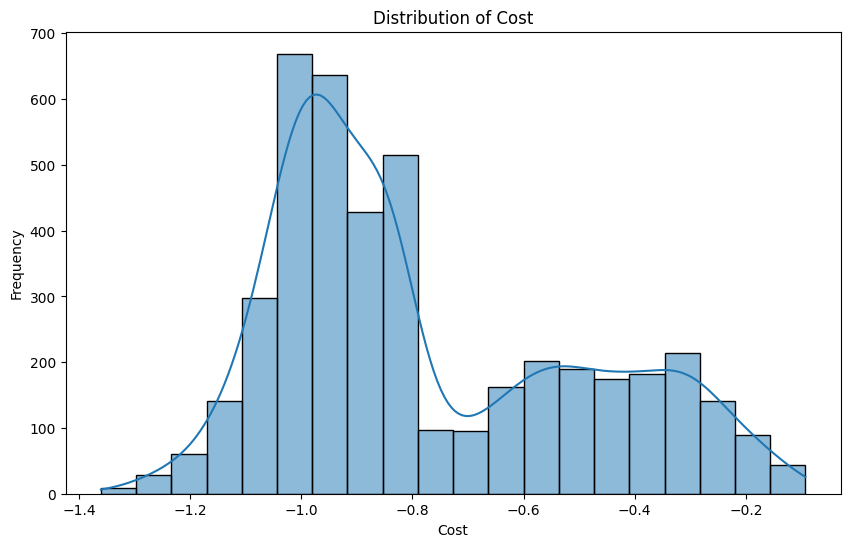

In [85]:
plt.figure(figsize=(10, 6))
sns.histplot(data=no_duplicate_df, x='cost', bins=20, kde=True)  # 绘制直方图和核密度估计曲线
plt.title('Distribution of Cost')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.show()

In [88]:
gdf_original = no_duplicate_df.loc[:, ['cost','geometry']]

In [89]:
gdf_original

,cost,geometry
0,-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
1,-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
2,-1.094822,LINESTRING (-74.00720977640854 40.746973999302...
3,-0.957720,LINESTRING (-74.00720977640854 40.746973999302...
4,-0.946085,LINESTRING (-74.00720977640854 40.746973999302...
...,...,...
4372,-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
4373,-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
4374,-0.600320,LINESTRING (-73.97780125392501 40.718332506285...
4375,-0.470082,LINESTRING (-73.97780125392501 40.718332506285...


In [90]:
geometry = gdf_original['geometry'].apply(LineString)

In [91]:
gdf_original = gpd.GeoDataFrame(gdf_original, geometry=geometry)

In [92]:
# Define the output shapefile path
output_shapefile = 'original.shp'

# Save the GeoDataFrame to a shapefile
gdf_original.to_file(output_shapefile)

# -----Mapping-----

In [232]:
graph = gpd.GeoDataFrame(columns=['edgeID', 'geometry'])

In [235]:
# 函数用于进行深度优先搜索
def dfs(node, max_edges):
    global graph  # 使用 global 关键字声明变量为全局变量
    edges = no_duplicate_df[no_duplicate_df['id_x'] == node].sort_values('cost')
    connected_edges = 0
    
    for _, edge in edges.iterrows():
        if graph[graph['edgeID'] == edge['edgeID']].shape[0] == 0:
            if graph[graph['geometry'].apply(lambda x: edge['geometry_x'].equals(x) or edge['geometry_y'].equals(x))].shape[0] < max_edges:
                # 检查id_y已连接的边数
                id_y_connected = graph[graph['geometry'].apply(lambda x: edge['geometry_y'].equals(x))].shape[0]
                if id_y_connected < 3:
                    graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
                    connected_edges += 1
                    dfs(edge['id_y'], max_edges)  # 递归调用DFS
            if connected_edges >= max_edges:
                break

# 逐个起始点处理
for start_point in no_duplicate_df['id_x'].unique():
    dfs(start_point, max_edges=3)

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.append(edge[['edgeID', 'geometry']], ignore_index=True)
/var/folders/d2/rwpl453n4zv0prg3wq7dgx900000gn/T/ipykernel_57247/4113689255.py:13: FutureWarning: The frame.append method is deprecated 

In [237]:
graph

,edgeID,geometry
0,1224,"LINESTRING (-74.00722 40.74722, -74.00698 40.7..."
1,1228,"LINESTRING (-74.00722 40.74722, -74.00722 40.7..."
2,442,"LINESTRING (-74.00722 40.74722, -74.00698 40.7..."
3,444,"LINESTRING (-74.00722 40.74722, -74.00788 40.7..."
4,443,"LINESTRING (-74.00788 40.74658, -74.00698 40.7..."
...,...,...
4185,4362,"LINESTRING (-73.98042 40.71520, -73.97976 40.7..."
4186,4360,"LINESTRING (-73.97976 40.71559, -73.98019 40.7..."
4187,2617,"LINESTRING (-73.97976 40.71559, -73.98005 40.7..."
4188,4359,"LINESTRING (-73.98042 40.71520, -73.98019 40.7..."


In [238]:
graph.to_file('mapping.shp')

# -----Filter cost for each p1-----

In [93]:
no_duplicate_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost,geometry
0,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
1,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
2,7781,2,7,POINT (-74.00721 40.74697),POINT (-74.00642 40.74663),-1.094822,LINESTRING (-74.00720977640854 40.746973999302...
3,159,2,4,POINT (-74.00721 40.74697),POINT (-74.00728 40.74667),-0.957720,LINESTRING (-74.00720977640854 40.746973999302...
4,156,2,0,POINT (-74.00721 40.74697),POINT (-74.00698 40.74748),-0.946085,LINESTRING (-74.00720977640854 40.746973999302...
...,...,...,...,...,...,...,...
4372,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
4373,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
4374,474,2298,1994,POINT (-73.97780 40.71833),POINT (-73.97780 40.71752),-0.600320,LINESTRING (-73.97780125392501 40.718332506285...
4375,473,2298,2014,POINT (-73.97780 40.71833),POINT (-73.97827 40.71847),-0.470082,LINESTRING (-73.97780125392501 40.718332506285...


In [94]:
sorted_df = no_duplicate_df.groupby('id_x').apply(lambda x: x.nsmallest(2, 'cost')).reset_index(drop=True)

In [95]:
sorted_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost,geometry
0,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
1,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
2,7781,2,7,POINT (-74.00721 40.74697),POINT (-74.00642 40.74663),-1.094822,LINESTRING (-74.00720977640854 40.746973999302...
3,159,2,4,POINT (-74.00721 40.74697),POINT (-74.00728 40.74667),-0.957720,LINESTRING (-74.00720977640854 40.746973999302...
4,442,3,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885486,LINESTRING (-74.00722100978008 40.747221133475...
...,...,...,...,...,...,...,...
3145,560,2296,2293,POINT (-73.97987 40.71361),POINT (-73.97965 40.71397),-0.918734,LINESTRING (-73.97987404430187 40.713608009757...
3146,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
3147,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
3148,474,2298,1994,POINT (-73.97780 40.71833),POINT (-73.97780 40.71752),-0.600320,LINESTRING (-73.97780125392501 40.718332506285...


In [96]:
p1_counts = no_duplicate_df['id_x'].value_counts()
p1_counts

531     7
50      6
447     6
1064    6
1677    6
       ..
1512    1
1515    1
1518    1
1519    1
1547    1
Name: id_x, Length: 1792, dtype: int64

In [97]:
# Count the occurrences of each unique 'p1' value
p1_counts = no_duplicate_df['id_x'].value_counts()

# Filter 'p1' values with more than 2 occurrences
filtered_p1 = p1_counts[p1_counts > 2].index

# Create a mask to identify rows to be removed
mask = no_duplicate_df['id_x'].isin(filtered_p1) & (no_duplicate_df.groupby('id_x')['cost'].rank(ascending=True) > 2)


In [98]:
mask

0       False
1       False
2       False
3       False
4        True
        ...  
4372    False
4373    False
4374    False
4375    False
4376     True
Length: 4377, dtype: bool

In [99]:
# Apply the mask and get the filtered DataFrame
no_duplicate_only_two_df = no_duplicate_df[~mask]

In [100]:
no_duplicate_only_two_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost,geometry
0,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
1,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
2,7781,2,7,POINT (-74.00721 40.74697),POINT (-74.00642 40.74663),-1.094822,LINESTRING (-74.00720977640854 40.746973999302...
3,159,2,4,POINT (-74.00721 40.74697),POINT (-74.00728 40.74667),-0.957720,LINESTRING (-74.00720977640854 40.746973999302...
6,442,3,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885486,LINESTRING (-74.00722100978008 40.747221133475...
...,...,...,...,...,...,...,...
4371,560,2296,2293,POINT (-73.97987 40.71361),POINT (-73.97965 40.71397),-0.918734,LINESTRING (-73.97987404430187 40.713608009757...
4372,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
4373,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
4374,474,2298,1994,POINT (-73.97780 40.71833),POINT (-73.97780 40.71752),-0.600320,LINESTRING (-73.97780125392501 40.718332506285...


In [101]:
no_duplicate_only_two_df = no_duplicate_only_two_df.loc[:, ['geometry', 'cost']]

In [102]:
no_duplicate_only_two_df

,geometry,cost
0,LINESTRING (-74.0072172653229 40.7472173890186...,-0.885181
1,LINESTRING (-74.0072172653229 40.7472173890186...,-0.819035
2,LINESTRING (-74.00720977640854 40.746973999302...,-1.094822
3,LINESTRING (-74.00720977640854 40.746973999302...,-0.957720
6,LINESTRING (-74.00722100978008 40.747221133475...,-0.885486
...,...,...
4371,LINESTRING (-73.97987404430187 40.713608009757...,-0.918734
4372,LINESTRING (-73.97987404430187 40.713608009757...,-0.873306
4373,LINESTRING (-73.98386708301707 40.720766081186...,-0.372962
4374,LINESTRING (-73.97780125392501 40.718332506285...,-0.600320


In [103]:
no_duplicate_only_two_df.iloc[9]

geometry    LINESTRING (-74.00642344040097 40.746629509241...
cost                                                -0.579292
Name: 12, dtype: object

In [104]:
geometry = no_duplicate_only_two_df['geometry'].apply(LineString)

In [105]:
no_duplicate_only_two_df = gpd.GeoDataFrame(no_duplicate_only_two_df, geometry=geometry)

In [106]:
# Define the output shapefile path
output_shapefile = 'GA_just_two.shp'

# Save the GeoDataFrame to a shapefile
no_duplicate_only_two_df.to_file(output_shapefile)

# -----Filter cost for each p1(lowerst)-----

In [107]:
no_duplicate_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost,geometry
0,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
1,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
2,7781,2,7,POINT (-74.00721 40.74697),POINT (-74.00642 40.74663),-1.094822,LINESTRING (-74.00720977640854 40.746973999302...
3,159,2,4,POINT (-74.00721 40.74697),POINT (-74.00728 40.74667),-0.957720,LINESTRING (-74.00720977640854 40.746973999302...
4,156,2,0,POINT (-74.00721 40.74697),POINT (-74.00698 40.74748),-0.946085,LINESTRING (-74.00720977640854 40.746973999302...
...,...,...,...,...,...,...,...
4372,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
4373,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
4374,474,2298,1994,POINT (-73.97780 40.71833),POINT (-73.97780 40.71752),-0.600320,LINESTRING (-73.97780125392501 40.718332506285...
4375,473,2298,2014,POINT (-73.97780 40.71833),POINT (-73.97827 40.71847),-0.470082,LINESTRING (-73.97780125392501 40.718332506285...


In [108]:
sorted_df = no_duplicate_df.groupby('id_x').apply(lambda x: x.nlargest(2, 'cost')).reset_index(drop=True)

In [109]:
sorted_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost,geometry
0,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
1,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
2,157,2,5,POINT (-74.00721 40.74697),POINT (-74.00788 40.74658),-0.935395,LINESTRING (-74.00720977640854 40.746973999302...
3,156,2,0,POINT (-74.00721 40.74697),POINT (-74.00698 40.74748),-0.946085,LINESTRING (-74.00720977640854 40.746973999302...
4,444,3,5,POINT (-74.00722 40.74722),POINT (-74.00788 40.74658),-0.325462,LINESTRING (-74.00722100978008 40.747221133475...
...,...,...,...,...,...,...,...
3145,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
3146,560,2296,2293,POINT (-73.97987 40.71361),POINT (-73.97965 40.71397),-0.918734,LINESTRING (-73.97987404430187 40.713608009757...
3147,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
3148,480,2298,2011,POINT (-73.97780 40.71833),POINT (-73.97715 40.71870),-0.231895,LINESTRING (-73.97780125392501 40.718332506285...


In [111]:
# Count the occurrences of each unique 'p1' value
p1_counts = no_duplicate_df['id_x'].value_counts()

# Filter 'p1' values with more than 2 occurrences
filtered_p1 = p1_counts[p1_counts > 2].index

# Create a mask to identify rows to be removed
mask = no_duplicate_df['id_x'].isin(filtered_p1) & (no_duplicate_df.groupby('id_x')['cost'].rank(ascending=False) > 2)


In [112]:
mask

0       False
1       False
2        True
3        True
4       False
        ...  
4372    False
4373    False
4374     True
4375    False
4376    False
Length: 4377, dtype: bool

In [113]:
# Apply the mask and get the filtered DataFrame
no_duplicate_only_two_df = no_duplicate_df[~mask]

In [114]:
no_duplicate_only_two_df

,edgeID,id_x,id_y,geometry_x,geometry_y,cost,geometry
0,1224,1,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885181,LINESTRING (-74.0072172653229 40.7472173890186...
1,1228,1,3,POINT (-74.00722 40.74722),POINT (-74.00722 40.74722),-0.819035,LINESTRING (-74.0072172653229 40.7472173890186...
4,156,2,0,POINT (-74.00721 40.74697),POINT (-74.00698 40.74748),-0.946085,LINESTRING (-74.00720977640854 40.746973999302...
5,157,2,5,POINT (-74.00721 40.74697),POINT (-74.00788 40.74658),-0.935395,LINESTRING (-74.00720977640854 40.746973999302...
6,442,3,0,POINT (-74.00722 40.74722),POINT (-74.00698 40.74748),-0.885486,LINESTRING (-74.00722100978008 40.747221133475...
...,...,...,...,...,...,...,...
4371,560,2296,2293,POINT (-73.97987 40.71361),POINT (-73.97965 40.71397),-0.918734,LINESTRING (-73.97987404430187 40.713608009757...
4372,554,2296,1942,POINT (-73.97987 40.71361),POINT (-73.97947 40.71296),-0.873306,LINESTRING (-73.97987404430187 40.713608009757...
4373,1561,2297,2212,POINT (-73.98387 40.72077),POINT (-73.98444 40.72049),-0.372962,LINESTRING (-73.98386708301707 40.720766081186...
4375,473,2298,2014,POINT (-73.97780 40.71833),POINT (-73.97827 40.71847),-0.470082,LINESTRING (-73.97780125392501 40.718332506285...


In [115]:
no_duplicate_only_two_df = no_duplicate_only_two_df.loc[:, ['geometry', 'cost']]

In [116]:
no_duplicate_only_two_df

,geometry,cost
0,LINESTRING (-74.0072172653229 40.7472173890186...,-0.885181
1,LINESTRING (-74.0072172653229 40.7472173890186...,-0.819035
4,LINESTRING (-74.00720977640854 40.746973999302...,-0.946085
5,LINESTRING (-74.00720977640854 40.746973999302...,-0.935395
6,LINESTRING (-74.00722100978008 40.747221133475...,-0.885486
...,...,...
4371,LINESTRING (-73.97987404430187 40.713608009757...,-0.918734
4372,LINESTRING (-73.97987404430187 40.713608009757...,-0.873306
4373,LINESTRING (-73.98386708301707 40.720766081186...,-0.372962
4375,LINESTRING (-73.97780125392501 40.718332506285...,-0.470082


In [117]:
geometry = no_duplicate_only_two_df['geometry'].apply(LineString)

In [118]:
no_duplicate_only_two_df = gpd.GeoDataFrame(no_duplicate_only_two_df, geometry=geometry)

In [119]:
# Define the output shapefile path
output_shapefile = 'GA_just_two_reverse.shp'

# Save the GeoDataFrame to a shapefile
no_duplicate_only_two_df.to_file(output_shapefile)

# -----Find triangle-----

In [116]:
def is_closed_triangle(p1, p2, p3):
    triangle = LineString([p1, p2, p3, p1])
    return triangle.is_closed and triangle.is_valid

In [267]:
def cost_function(angle):
    # Parameters for the Gaussian-like curve
    center1 = 0  # Centered around 0 degrees
    center2 = 45  # Centered around 45 degrees
    spread = 15  # Adjust the spread of the curve

    # Calculate the costs based on the Gaussian-like curve
    cost1 = np.exp(-0.5 * ((angle - center1) / spread)**2)
    cost2 = np.exp(-0.5 * ((angle - center2) / spread)**2)

    # Combine the costs and normalize to the [0, 1] range
    cost = (cost1 + cost2) / 2
    normalized_cost = (cost - min(cost1, cost2)) / (max(cost1, cost2) - min(cost1, cost2))
    
    return normalized_cost

# Example usage
angle_values = np.linspace(0, 90, 100)
cost_values = [cost_function(angle) for angle in angle_values]
cost_values

[0.49999999999999994,
 0.5,
 0.49999999999999994,
 0.5,
 0.5,
 0.5,
 0.49999999999999994,
 0.5000000000000001,
 0.5,
 0.49999999999999994,
 0.49999999999999994,
 0.5,
 0.5,
 0.4999999999999999,
 0.4999999999999999,
 0.5,
 0.5,
 0.49999999999999994,
 0.5,
 0.49999999999999994,
 0.5000000000000001,
 0.5,
 0.4999999999999999,
 0.4999999999999997,
 0.4999999999999994,
 0.5,
 0.4999999999999996,
 0.5,
 0.5000000000000001,
 0.49999999999999994,
 0.5000000000000001,
 0.5000000000000001,
 0.5000000000000001,
 0.5,
 0.5,
 0.5,
 0.5,
 0.5,
 0.49999999999999994,
 0.5000000000000001,
 0.5,
 0.49999999999999994,
 0.5,
 0.5000000000000001,
 0.49999999999999994,
 0.49999999999999994,
 0.49999999999999994,
 0.49999999999999994,
 0.5,
 0.49999999999999994,
 0.5000000000000001,
 0.5,
 0.5,
 0.5,
 0.5000000000000001,
 0.5000000000000001,
 0.49999999999999994,
 0.49999999999999994,
 0.5000000000000001,
 0.5,
 0.5,
 0.49999999999999994,
 0.49999999999999994,
 0.5,
 0.5,
 0.5000000000000001,
 0.5,
 0.500000